In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/microplastic-dataset-for-computer-vision
/kaggle/input/microplastic-dataset-for-computer-vision/valid
/kaggle/input/microplastic-dataset-for-computer-vision/train


# DATA

In [2]:
def get_data(path):
    images = []
    filename = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)
                img = Image.open(file_path)
                images.append(img)
                filename.append(file)
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
    return images, filename, df

In [3]:
train_dir = '/kaggle/input/microplastic-dataset-for-computer-vision/train'
val_dir = '/kaggle/input/microplastic-dataset-for-computer-vision/valid'

## Images & csv

In [4]:
# Get all images
train_img, train_filename, train_df = get_data(train_dir)
valid_img, val_filename, val_df = get_data(val_dir)

len(train_img), len(train_filename),len(train_df), len(valid_img), len(val_filename), len(val_df)

(577, 577, 5425, 204, 204, 1701)

Training: 577 images, 5425 annotation. 

Validation: 204 images, 1701 annotation.

## CSV check

In [5]:
val_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,271,15,305,46
1,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,348,265,402,308
2,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,146,279,181,317
3,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,477,302,542,367
4,f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5...,563,537,Microplastic,279,137,337,205


So the csv file contains the filename, the size and the bounding boxes that we are looking for.

Observation:
The first four lines of the head contain the same filename. 
Probably because an image can contain more than one bounding box, let's check it out

## Data exploration

In [6]:
val_unique_filename = val_df["filename"].unique()
train_unique_filename = train_df["filename"].unique()

len(train_unique_filename), len(val_unique_filename)

(577, 204)

In [7]:
def check_correpondance_filename(unique_filename, base_filename):
    for filename in unique_filename:
        if filename not in base_filename:
            # print a filename if is not in the folder valid  
            print(filename)

In [8]:
check_correpondance_filename(val_unique_filename, val_filename)

In [9]:
check_correpondance_filename(train_unique_filename, train_filename)

Each filename in the csv is also in the valid images folder.
We are sure that an image can contain more than one bounding box.

### Image size

Let's check the size of each image

In [10]:
val_unique_width = val_df["width"].unique()
val_unique_height = val_df["height"].unique()
train_unique_width = train_df["width"].unique()
train_unique_height = train_df["height"].unique()
len(train_unique_width), len(train_unique_height), len(val_unique_width), len(val_unique_height)

(2, 2, 1, 1)

In the training dataset there is two size let's check the distribution of each size in the dataset

In [11]:
def check_the_img_size(folder):
    for img in folder:
        # print only if there is another size
        if img.size != (563, 537):
            print(img.size)

In [12]:
check_the_img_size(train_img)

(353, 336)
(353, 336)
(353, 336)
(353, 336)


So, There are only four image with of different sizes in the train folder.

Since it is not a big loss of data, I will delete these images.

In [13]:
print(len(train_img))
train_img = [img for img in train_img if img.size == (563, 537)]
print(len(train_img))

577
573


Now we can work with the same size on each image.

### let's review what we're looking for

There is 18 bouding box on this images

We are going to create a function to plot these bounding boxes on the images.

In [14]:
def plot_bounding_boxes_on_img(dir_name, filename, df):
    
    # Groupby file name  
    grouped = df.groupby('filename')
    df_grouped_by_filename = grouped.get_group(filename)
    
    # Read image 
    print(dir_name)
    print(filename)
    img = plt.imread(os.path.join(dir_name, filename))

    # Get dimensions
    height, width = img.shape[:2]

    # Create figure 
    fig, ax = plt.subplots(1)

    # Display image
    ax.imshow(img)

    for xmin, ymin, xmax, ymax in zip(df_grouped_by_filename["xmin"], df_grouped_by_filename["ymin"],df_grouped_by_filename["xmax"], df_grouped_by_filename["ymax"]):
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

/kaggle/input/microplastic-dataset-for-computer-vision/valid
c--15-_jpg.rf.7b40ed7a869e48e2142b5a37aa10d1f3.jpg


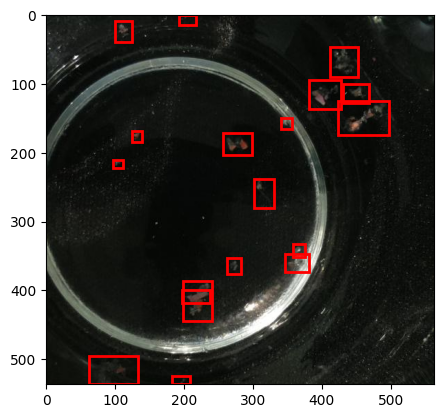

In [15]:
plot_bounding_boxes_on_img(val_dir, val_filename[0], val_df)

So we can have a clear view of what we are looking for.

What's next : 
1. Modeling
Use a convolutional neural network (CNN) based object detector like Faster R-CNN or YOLO. These models are designed for spatial detection tasks.
2. Evaluation
Calculate evaluation metrics like mean average precision (mAP), F1 score, intersection over union (IoU) to quantify accuracy.

In [16]:
%pip install ultralytics

ERROR: Could not find a version that satisfies the requirement ultralytics (from versions: none)
ERROR: No matching distribution found for ultralytics
Note: you may need to restart the kernel to use updated packages.


To use YOLO Environment need to be change. Help: write a comment if you know how to change the environment. 

Follow the link below for the Yolo implementation.

# Implementation of YOLOv8

The implementation of YOLOv8 continue on Google Colab https://colab.research.google.com/drive/1H8Poc-f0Sez9t0Im9kzFQ-EsV4JsQIWq?usp=sharing

## Results

To check all the metrics please follow this link: https://drive.google.com/drive/folders/16nJpPdvXzHKjzxK7fY1X79bQTvnsia9d?usp=sharing

### Base model
Parameters: 100 epoch, batch size 16, original size

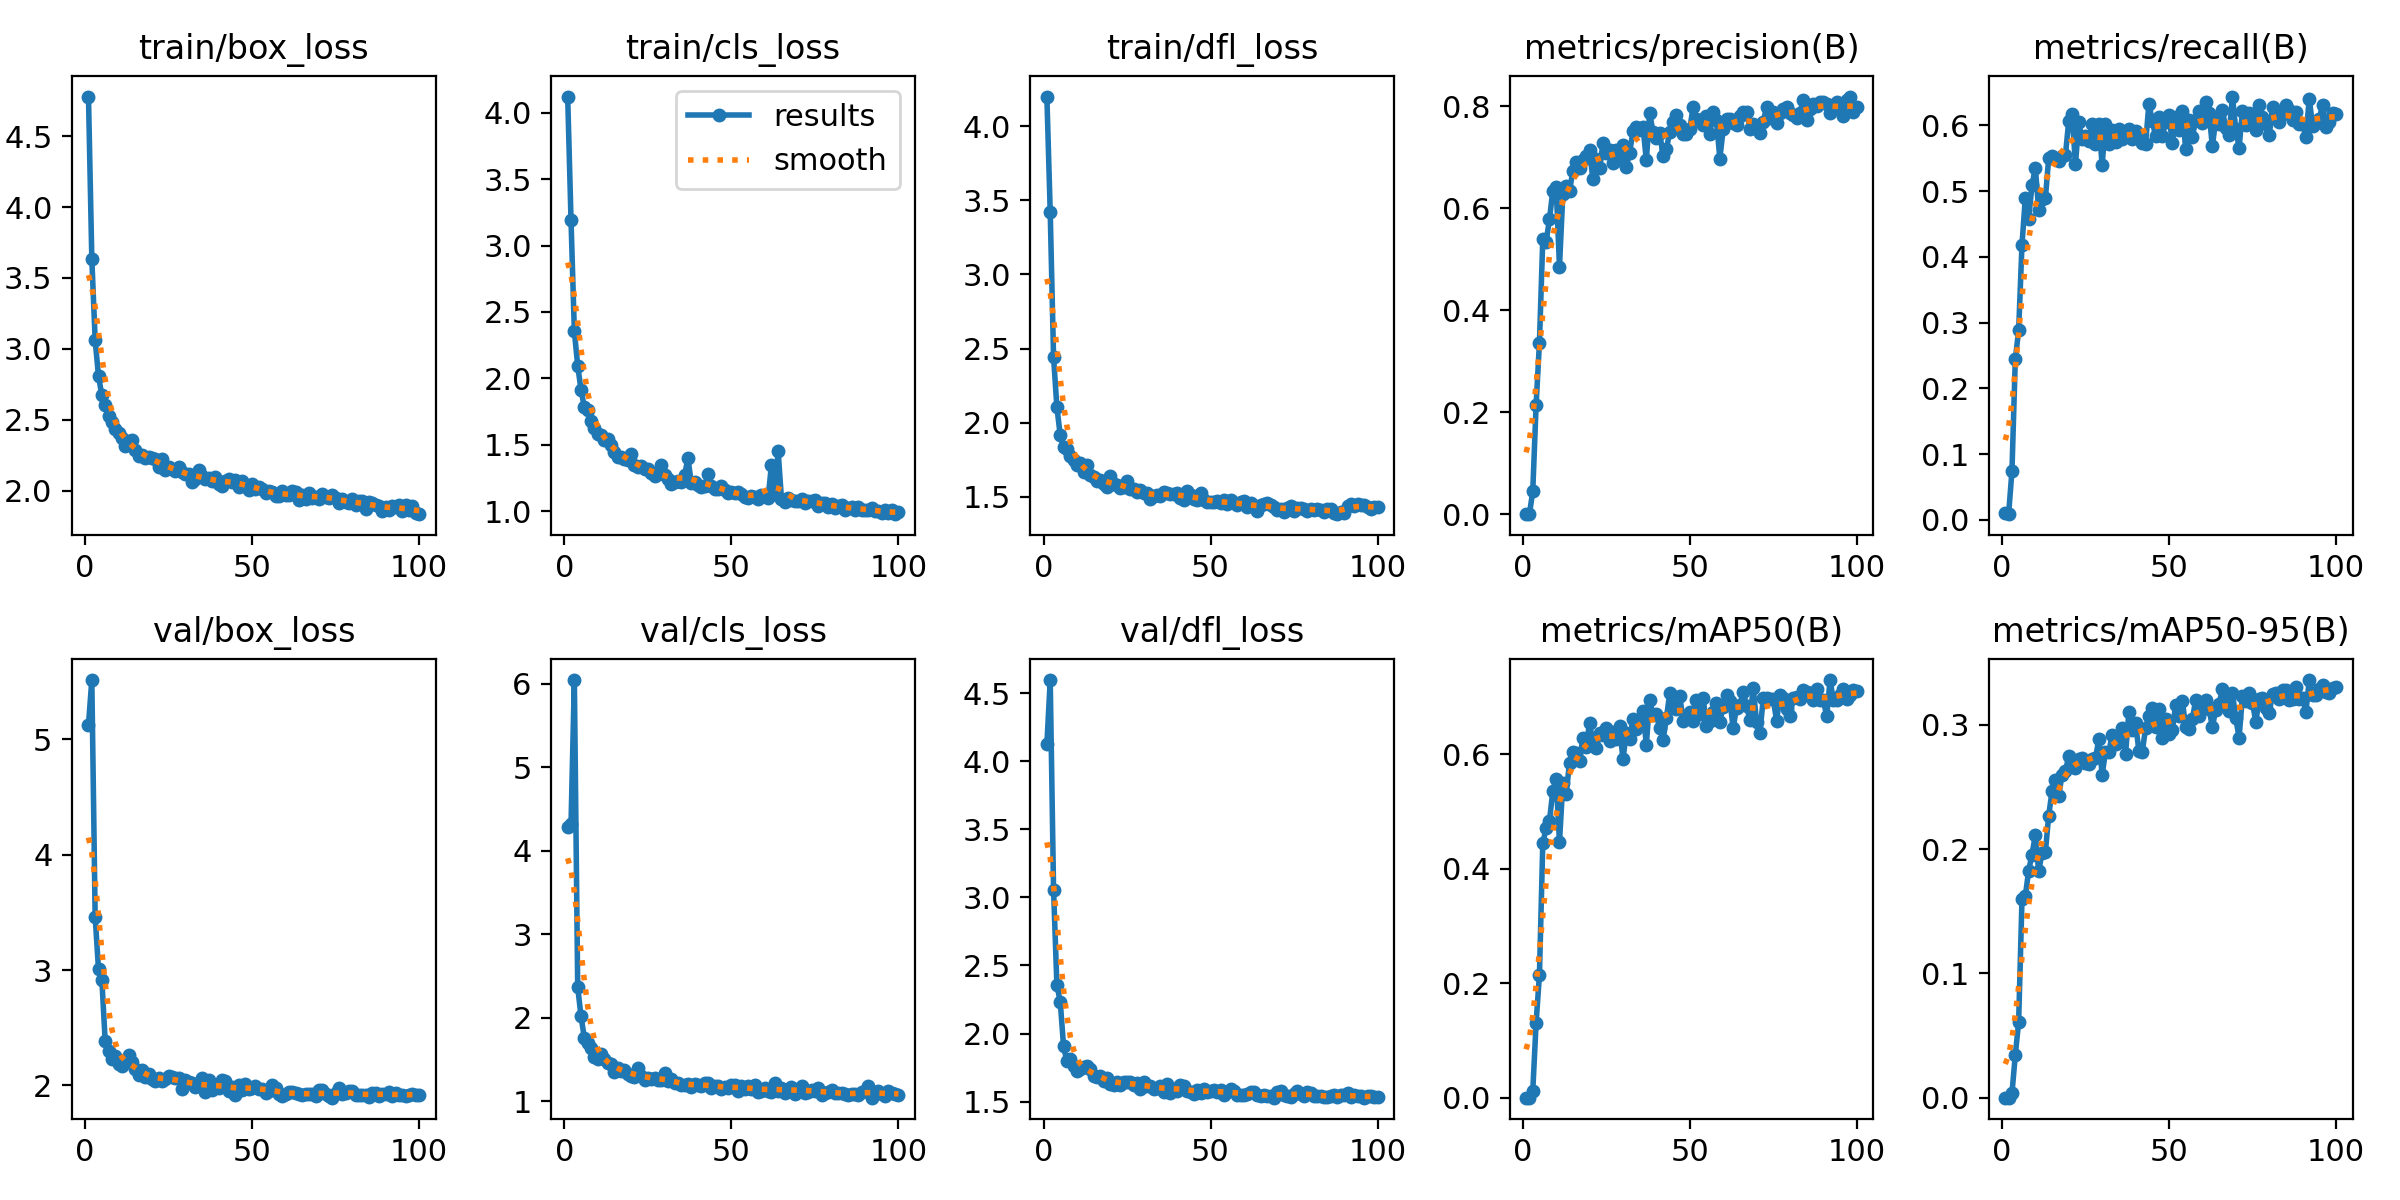

## Training Optimization

**I will conduct training experiments:**

    - Batch size: Using larger batches can provide more diverse examples per update, which acts as a regularization method and makes gradient updates more stable.
    Additionally, it allows for higher learning rates since gradient variance is reduced, which helps prevent getting trapped in local optima.
    
    - Image size: Larger input sizes can provide more context and help models learn greater translation invariance in object recognition, which can directly improve     metrics.
    This is especially beneficial for datasets that contain small objects, where seeing more context can aid in their detection.

### 1. Training experiments with image size increasing
Parameters: 150 epoch, batch size 16, **image size 1280**

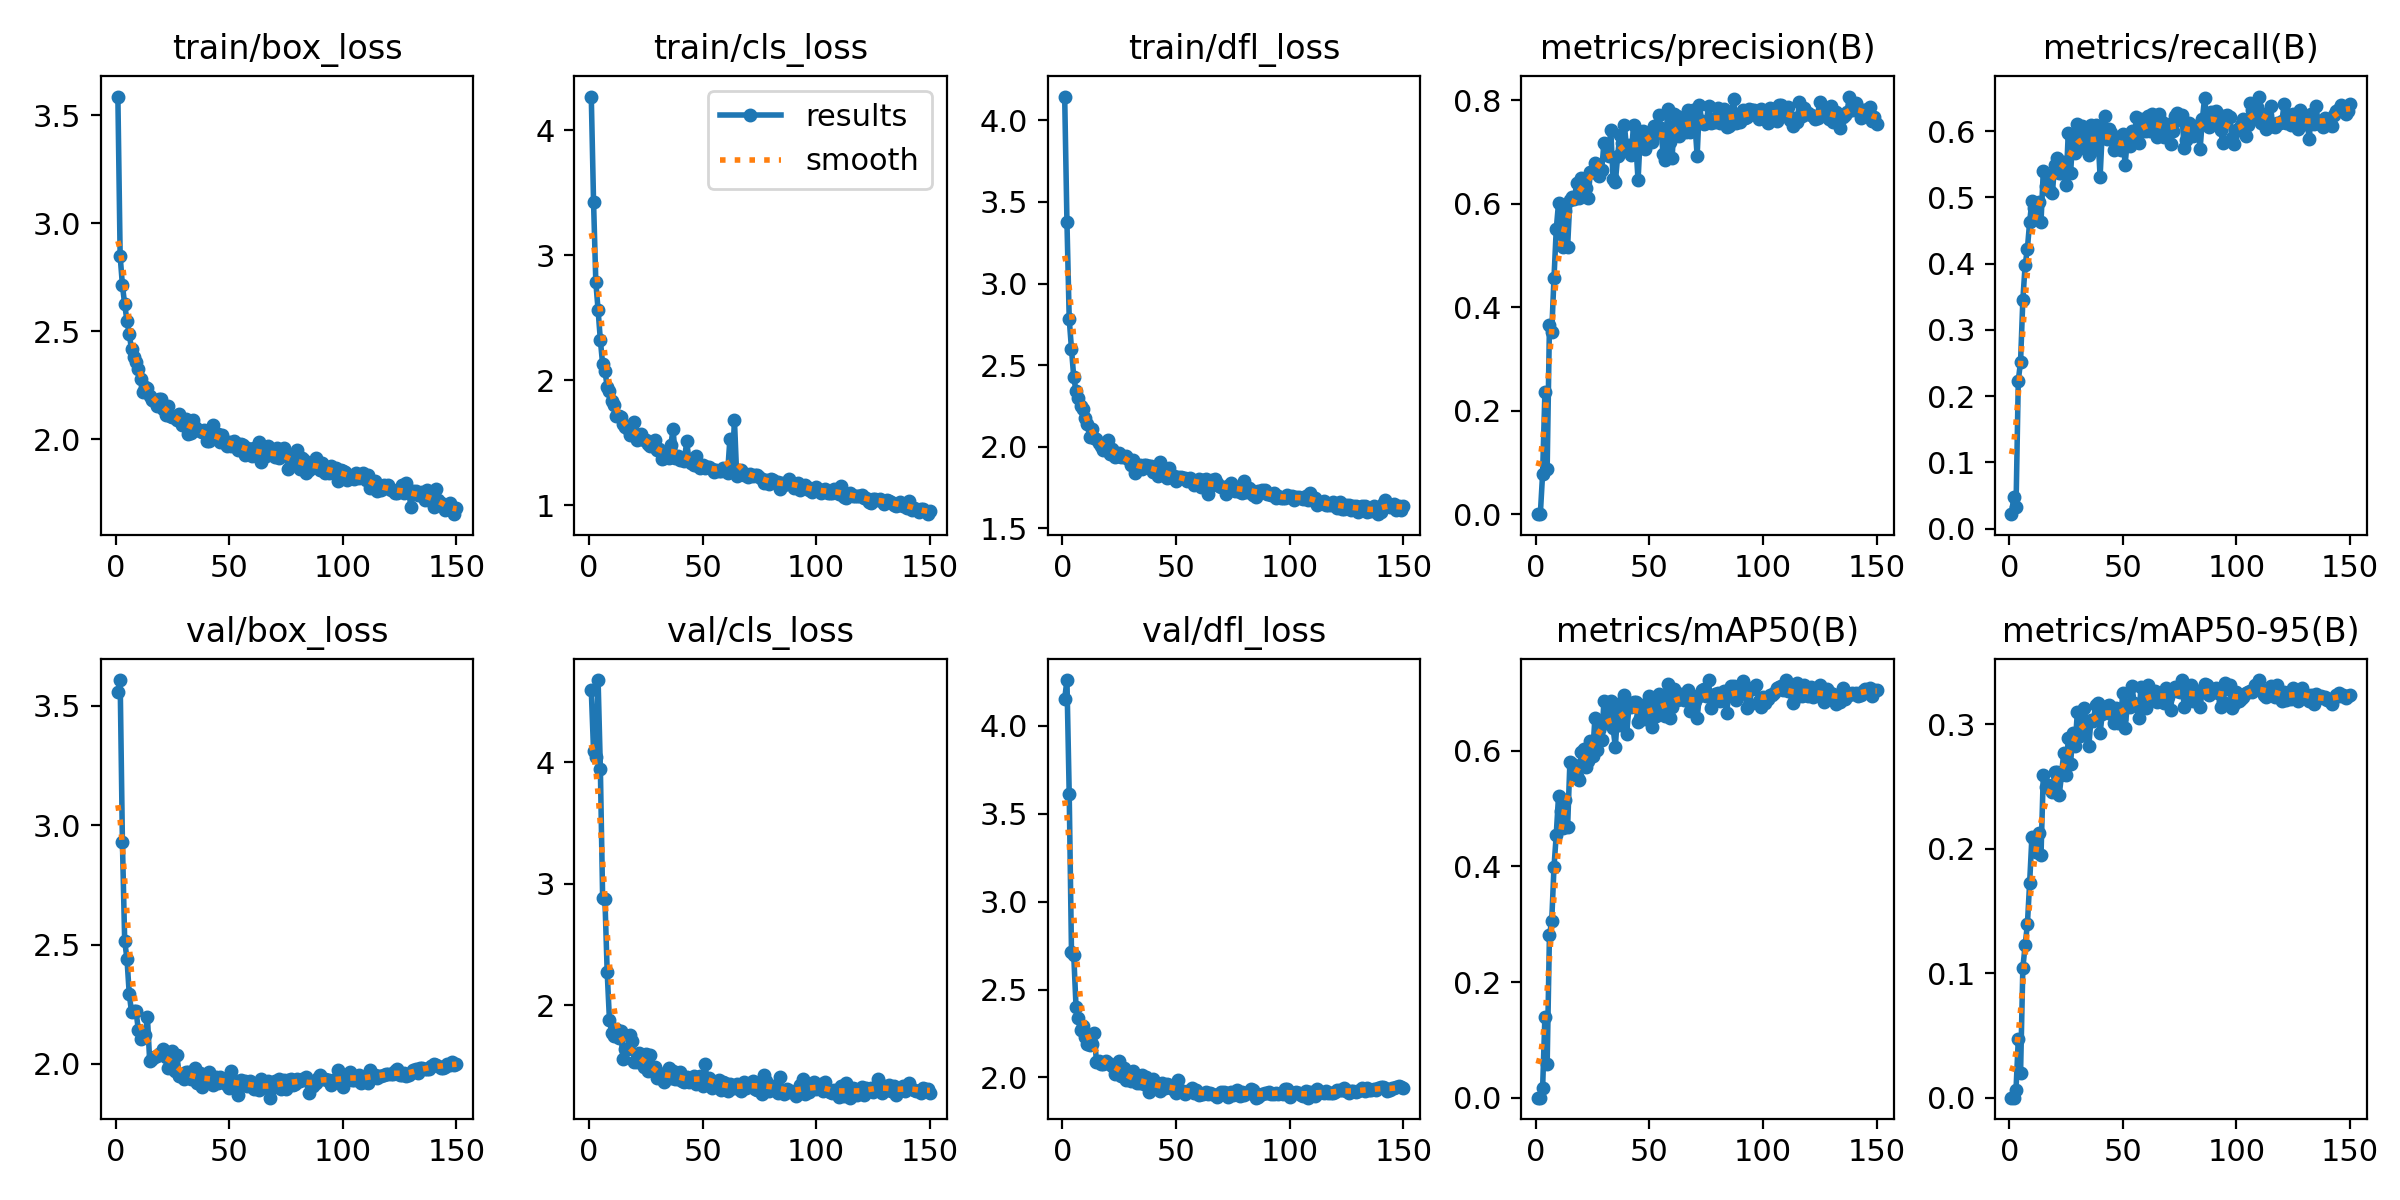

### 2. Training experiments with batch size increasing
Parameters: 100 epoch, **batch_size: 32**, image_size: 576

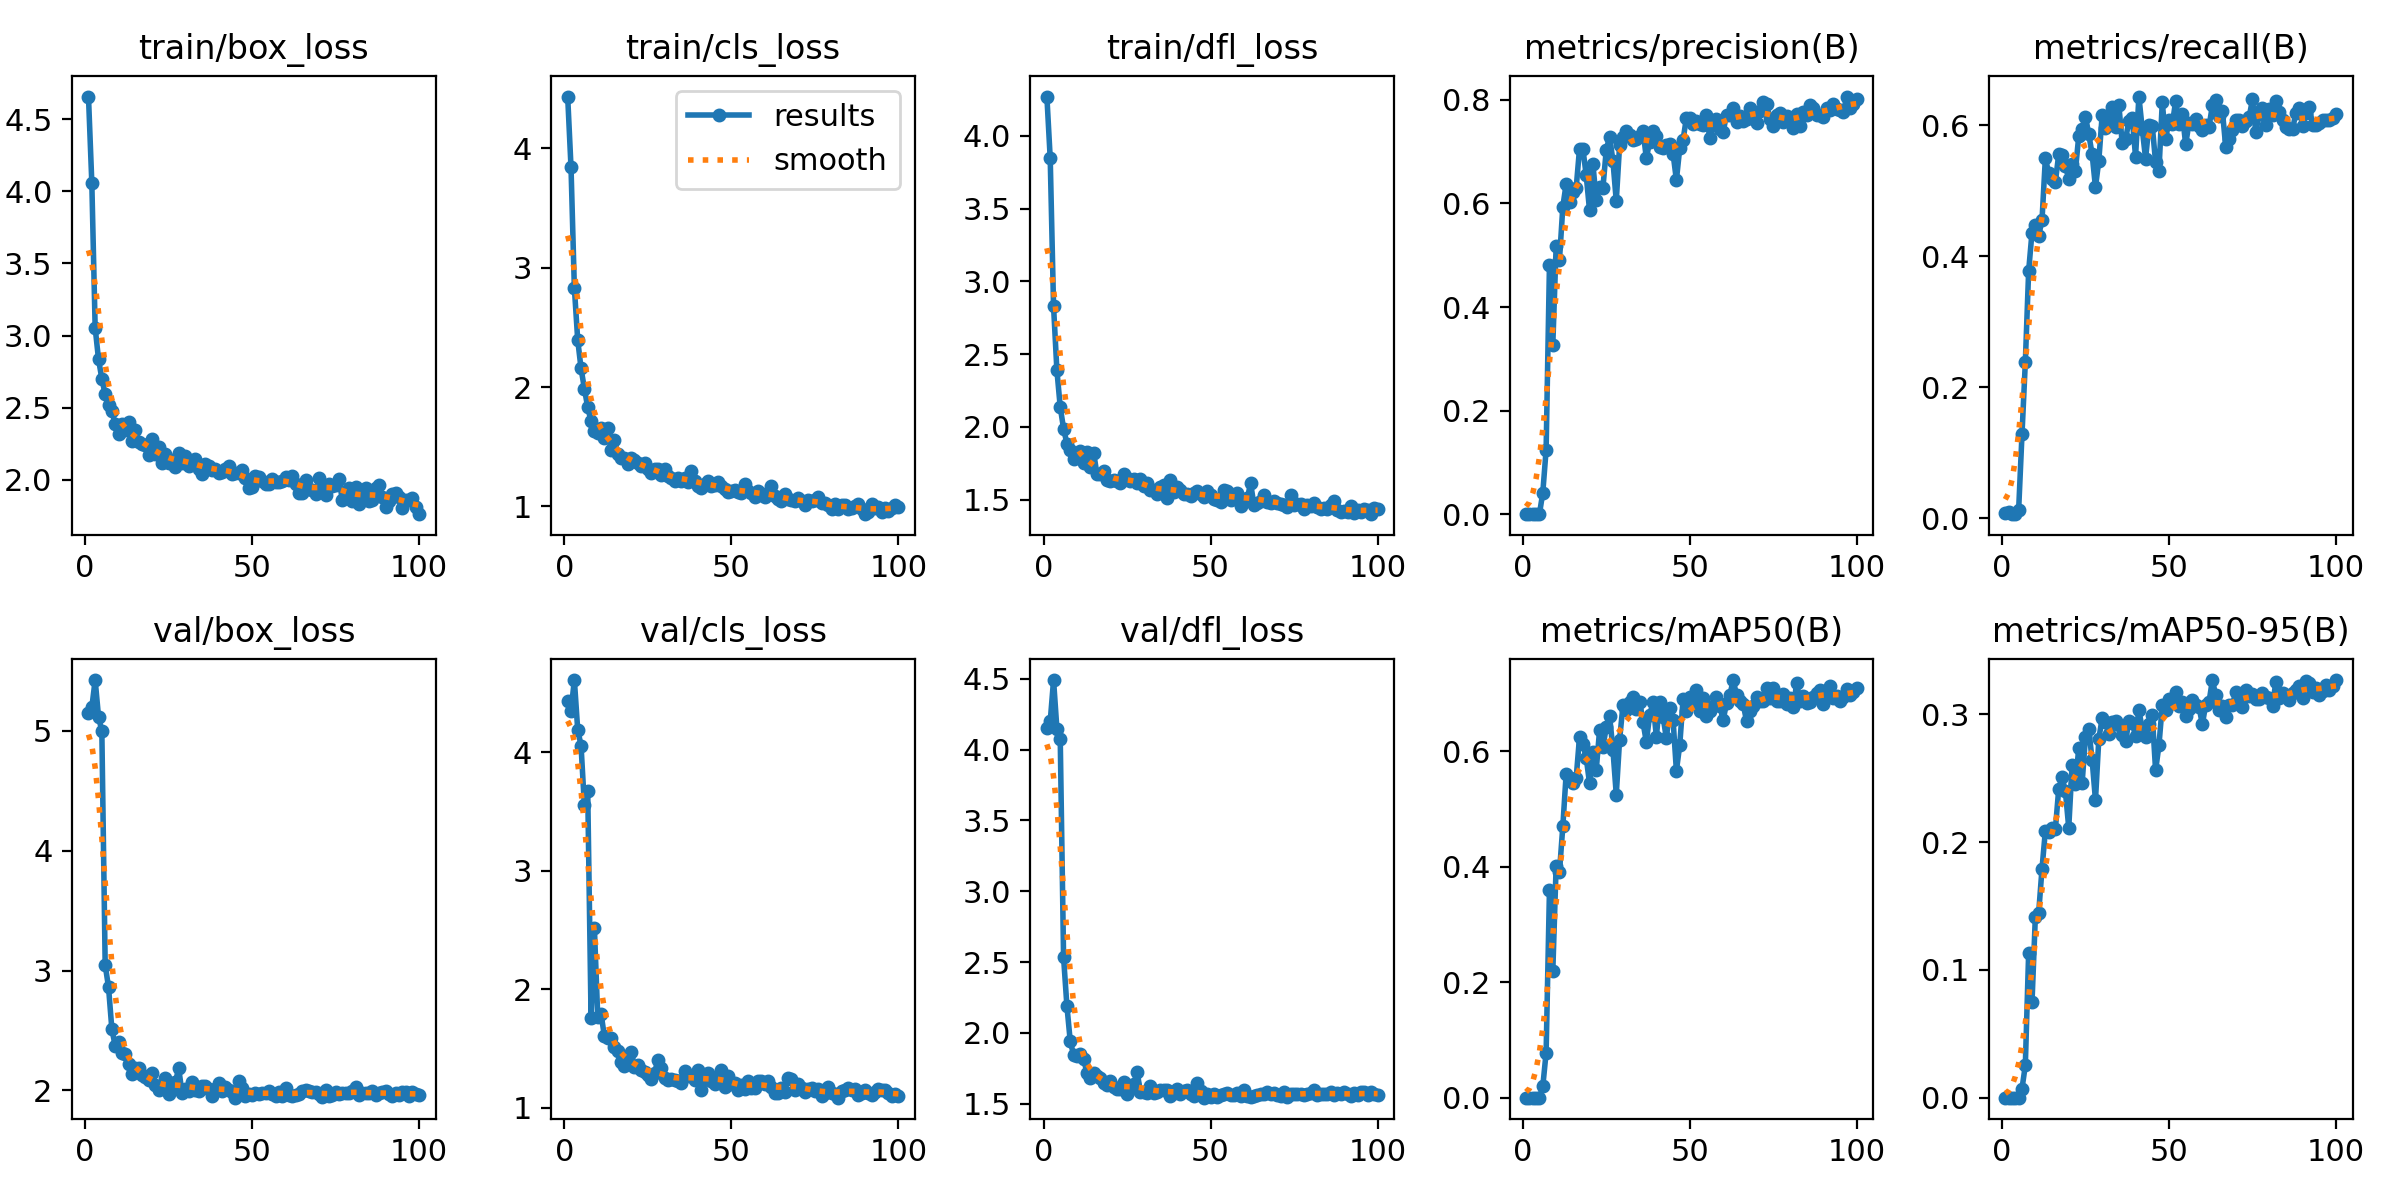

# Conclusion

The Increased Image Size model shows a significant improvement in Precision, Recall, and Mean Average Precision (mAP50 and mAP50-95) compared to the other models. It also has the lowest training box loss. However, this model has the highest validation DFL loss. These results suggest that increasing the image size to 1280 can improve the model's performance in certain key metrics.

# What's next:
1. Hyperparameters tuning
2. Enhanced Data Augmentation and Preprocessing
3. Increase the computations limits: Larger batch and image sizes require more GPU memory and compute power.